In [84]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
%matplotlib inline

In [180]:
NAME_REGEX = r"((checkpoint|events|args).*)|(report-dev-m(?P<d>1|0,1|0,0,1|)-(?P<s>[0-9]*)-(?P<t>train|eval|real)\.jsonl)"
DIST_TO_NUMBER = {"1" : 1, "0,1" : 2, "0,0,1" : 3, '' : 0}

In [193]:
def table_of_accuracies(logdir):
    data = []
    rel_logdir = os.path.join("..", logdir)
    for f in os.listdir(rel_logdir):
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
#         if not m.group("d"):
#             continue
        if m.group("d") is None:
            continue
        distance = DIST_TO_NUMBER[m.group("d")]
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(rel_logdir, f)) as fp:
            stats = json.loads(next(fp))
        if not stats.get('done', stats['total'] >= 2500):
            print(os.path.join(logdir, f))
            print(stats)
            continue
        data.append([distance, checkpoint, stats['correct'] / stats['total'], datatype])
    df = pd.DataFrame(
        data, columns=['Distance', 'Step', 'Accuracy', 'DataType']
    )
    train, val, real = df[df['DataType'] == 'train'], df[df['DataType'] == 'eval'], df[df['DataType'] == 'real']
    pivot = lambda x: x.pivot(index='Step', columns='Distance', values='Accuracy')
    return pivot(train), pivot(val), pivot(real)

In [216]:
def plot_accuracies(train_val):
    COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
    def plot(accuracies, label, fmt):
        assert len(list(accuracies)) <= len(COLORS)
        for i, dist in enumerate(accuracies):
            plt.plot(accuracies[dist] * 100, fmt, label="{}, Distance={}".format(label, dist), color=COLORS[i])
        plt.xlabel("Step")
        plt.ylabel("Accuracy [%]")
        plt.legend()
    plot(train_val[0], label='train', fmt='-')
    plot(train_val[1], label='val', fmt='--')

def plot_combined_accuracy(table, label):
    cols = sorted(table.columns)
    assert cols == [1, 2, 3] or cols == [0]
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()


In [217]:
vanilla_accuracies = table_of_accuracies("logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/")

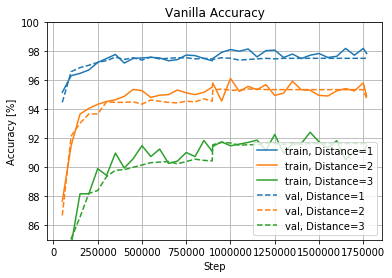

In [219]:
plot_accuracies(vanilla_accuracies)
plt.title("Vanilla Accuracy")
plt.grid()
plt.ylim(85, 100)
plt.show()

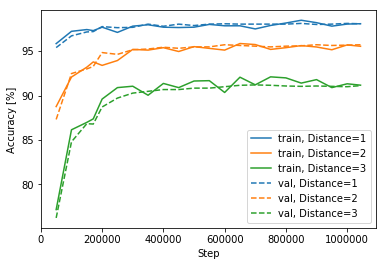

In [220]:
trace_accuracies = table_of_accuracies("logdirs/aggregate-standard,trace_enc==aggregate,batch_size==64,lr==1,lr_decay_steps=100000/")
plot_accuracies(trace_accuracies)

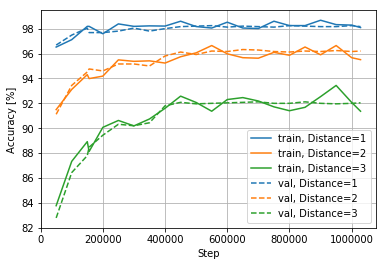

In [221]:
trace_accuracies_with_io = table_of_accuracies("logdirs/aggregate-with-io,trace_enc==aggregate:conv_all_grids=True,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io)
plt.grid()

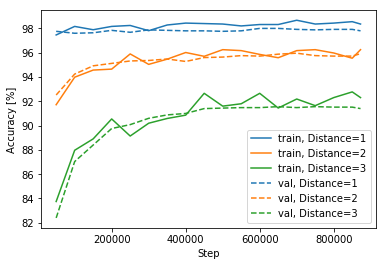

In [222]:
trace_accuracies_with_io_and_rnn = table_of_accuracies("logdirs/aggregate-with-io-rnn-traces,trace_enc==aggregate:conv_all_grids=True,rnn_trace=True,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_rnn)

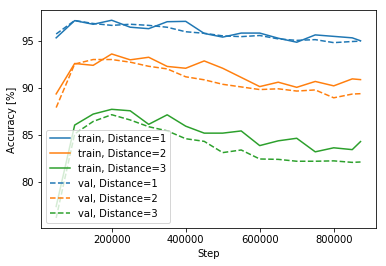

In [223]:
trace_accuracies_with_io_and_graph_conv10 = table_of_accuracies("logdirs/aggregate-with-io-graphconv-traces,trace_enc==aggregate:conv_all_grids=True,graph_conv_trace=True,graph_conv_trace_layers=10,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_graph_conv10)

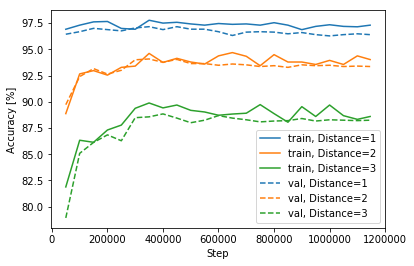

In [224]:
trace_accuracies_with_io_and_graph_conv3 = table_of_accuracies("logdirs/aggregate-with-io-graphconv-traces-fewer-layers,trace_enc==aggregate:conv_all_grids=True,graph_conv_trace=True,graph_conv_trace_layers=3,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_graph_conv3)

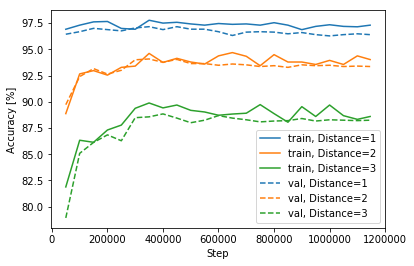

In [225]:
trace_accuracies_with_io_and_graph_conv3 = table_of_accuracies("logdirs/aggregate-with-io-graphconv-traces-fewer-layers,trace_enc==aggregate:conv_all_grids=True,graph_conv_trace=True,graph_conv_trace_layers=3,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_graph_conv3)

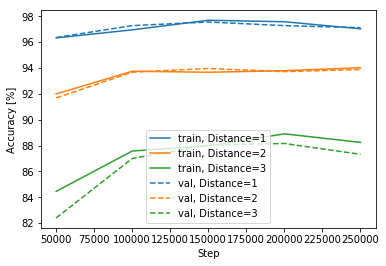

In [226]:
trace_accuracies_with_io_and_attention = table_of_accuracies("logdirs/aggregate-with-io-attention,trace_enc==aggregate:conv_all_grids=True,attention_trace=True,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_attention)

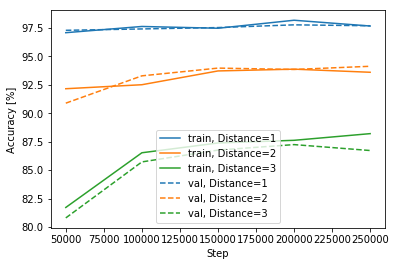

In [227]:
trace_accuracies_with_io_and_attention_rnn = table_of_accuracies("logdirs/aggregate-with-io-attention-rnn-traces,trace_enc==aggregate:conv_all_grids=True,attention_trace=True,rnn_trace=True,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io_and_attention_rnn)

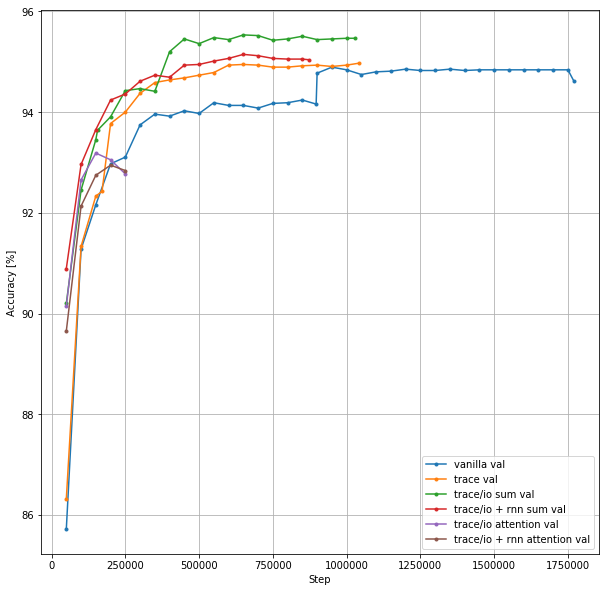

In [228]:
plt.figure(figsize=(10, 10))
plot_combined_accuracy(vanilla_accuracies[1], "vanilla val")
plot_combined_accuracy(trace_accuracies[1], "trace val")
plot_combined_accuracy(trace_accuracies_with_io[1], "trace/io sum val")
plot_combined_accuracy(trace_accuracies_with_io_and_rnn[1], "trace/io + rnn sum val")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv10[0], "trace/io + conv10 train")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv10[1], "trace/io + graph_conv10 val")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv3[0], "trace/io + graph_conv3 train")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv3[1], "trace/io + graph_conv3 val")
plot_combined_accuracy(trace_accuracies_with_io_and_attention[1], "trace/io attention val")
plot_combined_accuracy(trace_accuracies_with_io_and_attention_rnn[1], "trace/io + rnn attention val")
# plt.axhline(95)
plt.grid()
plt.show()

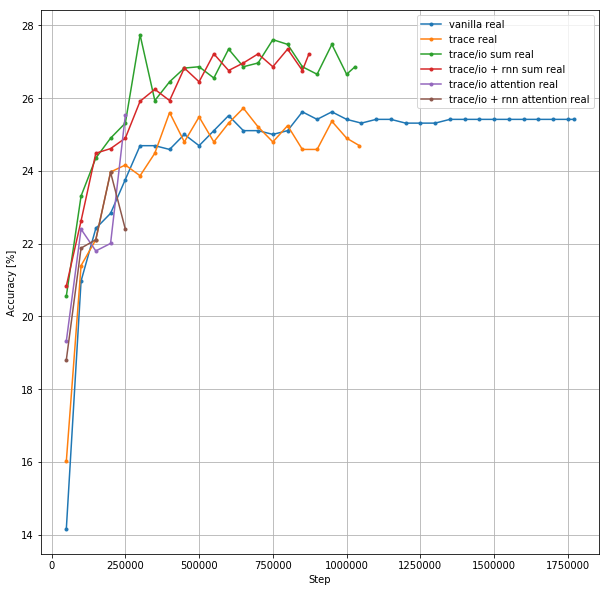

In [229]:
plt.figure(figsize=(10, 10))
plot_combined_accuracy(vanilla_accuracies[2], "vanilla real")
plot_combined_accuracy(trace_accuracies[2], "trace real")
plot_combined_accuracy(trace_accuracies_with_io[2], "trace/io sum real")
plot_combined_accuracy(trace_accuracies_with_io_and_rnn[2], "trace/io + rnn sum real")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv10[0], "trace/io + conv10 train")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv10[1], "trace/io + graph_conv10 val")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv3[0], "trace/io + graph_conv3 train")
# plot_combined_accuracy(trace_accuracies_with_io_and_graph_conv3[1], "trace/io + graph_conv3 val")
plot_combined_accuracy(trace_accuracies_with_io_and_attention[2], "trace/io attention real")
plot_combined_accuracy(trace_accuracies_with_io_and_attention_rnn[2], "trace/io + rnn attention real")
# plt.axhline(95)
plt.grid()
plt.show()